# 1802959
# Adham Mohamed Saber Hussein Osman
# CSE 477s: Project 2

# This cell is only required to load the data into google colab

In [1]:
!pip install -q kaggle
from google.colab import files
files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download 'zalando-research/fashionmnist'
!unzip fashionmnist.zip

Saving kaggle.json to kaggle.json
 97% 67.0M/68.8M [00:02<00:00, 44.9MB/s]
100% 68.8M/68.8M [00:02<00:00, 35.3MB/s]
Archive:  fashionmnist.zip
  inflating: fashion-mnist_test.csv  
  inflating: fashion-mnist_train.csv  
  inflating: t10k-images-idx3-ubyte  
  inflating: t10k-labels-idx1-ubyte  
  inflating: train-images-idx3-ubyte  
  inflating: train-labels-idx1-ubyte  


# Import the required Packages

In [1]:
import pandas as pd
import numpy as np
np.random.seed(1)
from matplotlib import pyplot as plt
import tensorflow as tf
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, AveragePooling2D, Flatten, GlobalAveragePooling2D, Input, Lambda, Dropout
from keras.callbacks import EarlyStopping, Callback, ReduceLROnPlateau
from IPython.display import clear_output
from fastai.imports import *
import imageio

# Data Loading and Decsription

In [3]:
train=pd.read_csv('fashion-mnist_train.csv')
test=pd.read_csv('fashion-mnist_test.csv')

train.describe()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
count,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,...,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.00000
mean,4.500000,0.000900,0.006150,0.035333,0.101933,0.247967,0.411467,0.805767,2.198283,5.682000,...,34.625400,23.300683,16.588267,17.869433,22.814817,17.911483,8.520633,2.753300,0.855517,0.07025
std,2.872305,0.094689,0.271011,1.222324,2.452871,4.306912,5.836188,8.215169,14.093378,23.819481,...,57.545242,48.854427,41.979611,43.966032,51.830477,45.149388,29.614859,17.397652,9.356960,2.12587
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,4.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,58.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
max,9.000000,16.000000,36.000000,226.000000,164.000000,227.000000,230.000000,224.000000,255.000000,254.000000,...,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,170.00000


In [4]:
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
X_train=np.array(train, dtype='float32')[:, 1:]/255
y_train=np.array(train, dtype='float32')[:, 0]
X_test=np.array(test, dtype='float32')[:, 1:]/255
y_test=np.array(test, dtype='float32')[:, 0]

In [6]:
X_train = X_train.reshape(X_train.shape[0], 28, 28)
X_test = X_test.reshape(X_test.shape[0], 28, 28)

# Images Visualization

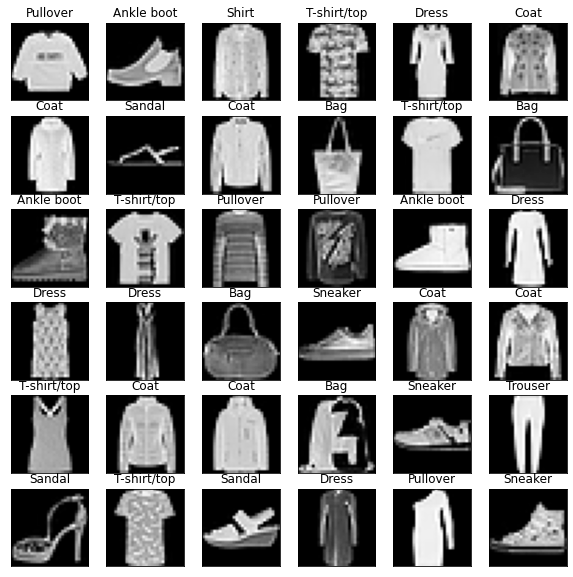

In [7]:
class_names=['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

plt.figure(figsize=(10, 10))
for i in range(0, 36):
    plt.subplot(6, 6, i+1)
    plt.imshow(X_train[i], cmap='gray')
    plt.title(class_names[int(y_train[i])])
    plt.xticks([])
    plt.yticks([])
plt.show()

# A Class to Plot Model Loss and Accuracy During Training in Keras

In [8]:
class PlotLearning(Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        # Plotting
        metrics = [x for x in logs if 'val' not in x]
        
        f, axs = plt.subplots(1, 2, figsize=(15,5))
        clear_output(wait=True)

        for i, metric in enumerate(metrics):
            if not(metric == 'lr'):
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics[metric], 
                            label=metric)
            
                if logs['val_' + metric]:
                    axs[i].plot(range(1, epoch + 2), 
                                self.metrics['val_' + metric], 
                                label='val_' + metric)

                axs[i].legend()
                axs[i].grid()

        plt.tight_layout()
        plt.show()

# Hyperparameter Tuning Using K-Fold Cross Validation

In [9]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [10]:
# define 5-fold cross validation test harness
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
cvscores = []
for train, test in kfold.split(X_train, y_train):
    # create model
    model = Sequential()
    model.add(Conv2D(filters=6, kernel_size=5, padding = 'same', activation='tanh', input_shape = (28, 28, 1)))
    model.add(BatchNormalization(axis=3))
    model.add(AveragePooling2D())
    
    model.add(Conv2D(filters=16, kernel_size=5, activation='tanh'))
    model.add(BatchNormalization(axis=3))
    model.add(AveragePooling2D())
    
    model.add(Conv2D(filters=120, kernel_size=5, activation='tanh'))
    model.add(BatchNormalization(axis=3))
    
    model.add(Flatten())
    model.add(Dense(84, activation='tanh'))
    model.add(Dense(10, activation='softmax'))
    
    # Compile model
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # Fit the model
    early_stopping = EarlyStopping(monitor='val_loss', patience=6)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.00001)
    model.fit(X_train[train], y_train[train], epochs=20, batch_size=32, validation_data=(X_train[test], y_train[test]),
              verbose=0, callbacks=[reduce_lr, early_stopping])
    # evaluate the model
    scores = model.evaluate(X_train[test], y_train[test], verbose=0)
#     print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
print()
print("Validation Accuracy = %.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))


Validation Accuracy = 90.96% (+/- 0.21%)


# LeNet-5 Training using the Best Model

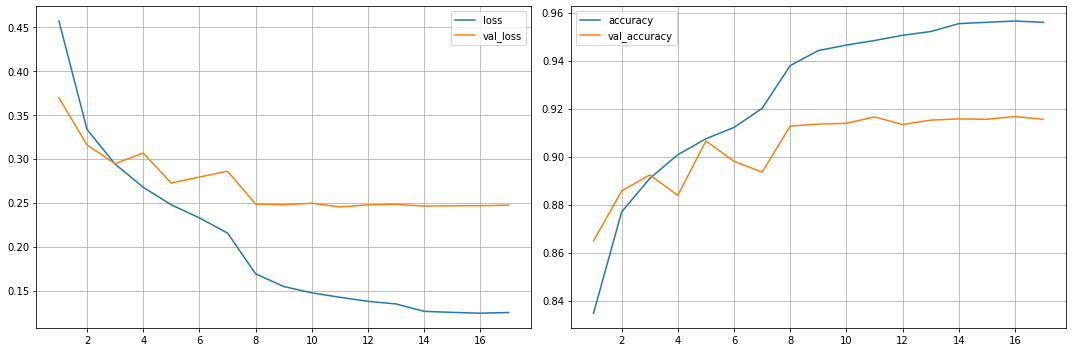

313/313 [==============================] - 1s 3ms/step - loss: 0.2422 - accuracy: 0.9130


[0.24221022427082062, 0.9129999876022339]

In [11]:
model = Sequential()
model.add(Conv2D(filters=6, kernel_size=5, padding = 'same', activation='tanh', input_shape = (28, 28, 1)))
model.add(BatchNormalization(axis=3))
model.add(AveragePooling2D())

model.add(Conv2D(filters=16, kernel_size=5, activation='tanh'))
model.add(BatchNormalization(axis=3))
model.add(AveragePooling2D())

model.add(Conv2D(filters=120, kernel_size=5, activation='tanh'))
model.add(BatchNormalization(axis=3))

model.add(Flatten())
model.add(Dense(84, activation='tanh'))
model.add(Dense(10, activation='softmax'))

# Compile model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# Fit the model
early_stopping = EarlyStopping(monitor='val_loss', patience=6)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.00001)
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=.1,verbose=0, callbacks=[reduce_lr, early_stopping, PlotLearning()])

model.evaluate(X_test, y_test)

# Adding two more Channels

In [12]:
X_train_tl = X_train.reshape(X_train.shape[0], 28, 28)
X_test_tl = X_test.reshape(X_test.shape[0], 28, 28)

X_train_tl = np.repeat(X_train_tl[..., np.newaxis], 3, -1)
X_test_tl = np.repeat(X_test_tl[..., np.newaxis], 3, -1)

print(X_train_tl.shape)
print(X_test_tl.shape)

(60000, 28, 28, 3)
(10000, 28, 28, 3)


# Sanity Check after adding the channels

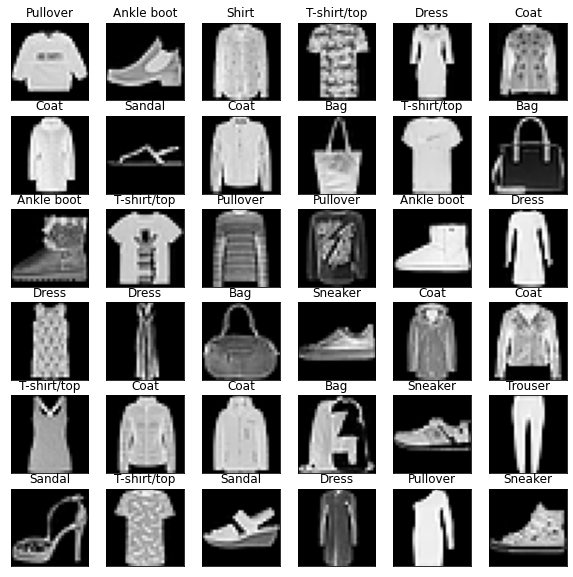

In [13]:
plt.figure(figsize=(10, 10))
for i in range(0, 36):
    plt.subplot(6, 6, i+1)
    plt.imshow(X_train_tl[i])
    plt.title(class_names[int(y_train[i])])
    plt.xticks([])
    plt.yticks([])
plt.show()

# Transfer Learning using MobileNetV2

In [2]:
input_image = Input(shape=(28, 28, 3))
resized_input = Lambda(lambda x: tf.image.resize(x, (32, 32)), input_shape=(28,28,3))(input_image)
model = tf.keras.applications.MobileNetV2(input_tensor=resized_input, include_top=False, weights='imagenet')

# Freeze all the layers
for layer in model.layers[:152]:
    layer.trainable = False

output = model.output
output = GlobalAveragePooling2D()(output)
output = Flatten()(output)
output = Dense(units=84, activation='relu')(output)
output = Dense(units=10, activation='softmax')(output)
model = Model(model.input, output)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 3)]  0           []                               
                                                                                                  
 lambda (Lambda)                (None, 32, 32, 3)    0           ['input_1[0][0]']                
                                                                                                  
 Conv1 (Conv2D)                 (None, 16, 16, 32)   864         ['lambda[0][0]']                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 16, 16, 32)   128         ['Conv1[0][0]']                  
                                                                                              

 block_3_pad (ZeroPadding2D)    (None, 9, 9, 144)    0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 4, 4, 144)   1296        ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 4, 4, 144)   576         ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_depthwise_relu (ReLU)  (None, 4, 4, 144)    0           ['block_3_depthwise_BN[0][0]']   
                                                                                                  
 block_3_p

 block_7_expand (Conv2D)        (None, 2, 2, 384)    24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 2, 2, 384)   1536        ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 2, 2, 384)    0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 2, 2, 384)   3456        ['block_7_expand_relu[0][0]']    
 nv2D)                                                                                            
                                                                                                  
 block_7_d

                                                                                                  
 block_10_project (Conv2D)      (None, 2, 2, 96)     36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 2, 2, 96)    384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 2, 2, 576)    55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_expand_BN (BatchNorma  (None, 2, 2, 576)   2304        ['block_11_expand[0][0]']        
 lization)                                                                                        
          

                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 1, 1, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 1, 1, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 1, 1, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_project_BN (BatchNorm  (None, 1, 1, 160)   640         ['block_14_project[0][0]']       
 alization)                                                                                       
          

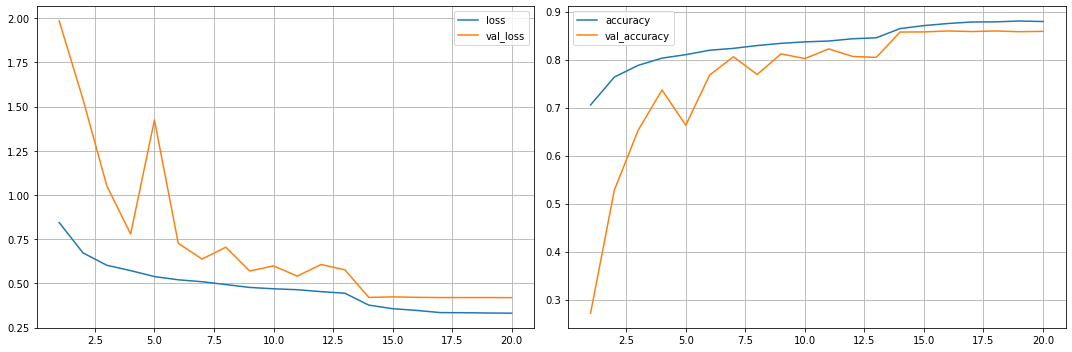

313/313 [==============================] - 3s 8ms/step - loss: 0.3997 - accuracy: 0.8605


[0.3996818959712982, 0.8604999780654907]

In [35]:
# Compile model
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              metrics=['accuracy'])
# Fit the model
early_stopping = EarlyStopping(monitor='val_loss', patience=6)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.00001)
model.fit(X_train_tl, y_train, epochs=20, batch_size=32, validation_split=.1, verbose=1,
          callbacks=[reduce_lr, early_stopping, PlotLearning()])

model.evaluate(X_test_tl, y_test)

In [36]:
len(model.layers)

159

In [3]:
model.layers[152].name

'Conv_1'

# Fine-Tuning the MobileNetV2 model after Convergence

Once the model has converged on the new data, I try to unfreeze all of the base model and retrain the whole model end-to-end with a (very low) learning rate.

That can potentially give incremental improvements.

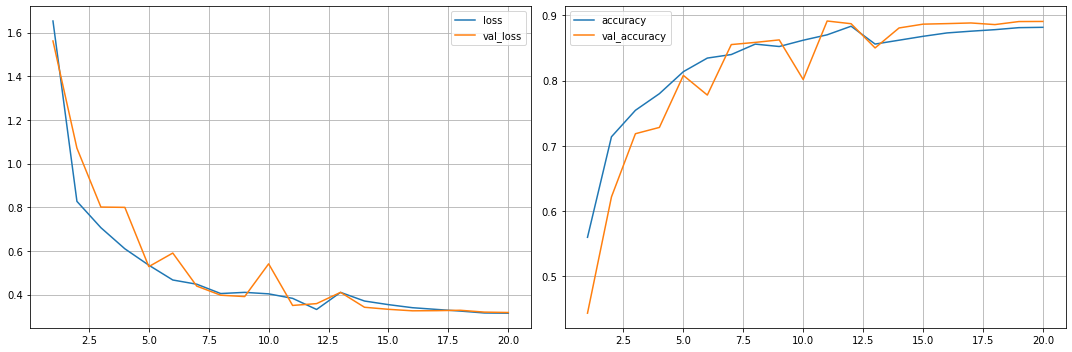

313/313 [==============================] - 3s 8ms/step - loss: 0.3003 - accuracy: 0.8943


[0.30026721954345703, 0.8942999839782715]

In [38]:
model.trainable = True
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              metrics=['accuracy'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=1e-7)
model.fit(X_train_tl, y_train, epochs=20, batch_size=32, validation_split=.1, verbose=1,
          callbacks=[reduce_lr, early_stopping, PlotLearning()])

model.evaluate(X_test_tl, y_test)

# Transfer Learning using DenseNet121

In [4]:
input_image = Input(shape=(28, 28, 3))
resized_input = Lambda(lambda x: tf.image.resize(x, (32, 32)), input_shape=(28,28,3))(input_image)
model = tf.keras.applications.DenseNet121(input_tensor=resized_input, include_top=False, weights='imagenet')

# Freeze all the layers
for layer in model.layers[:425]:
    layer.trainable = False

output = model.output
output = GlobalAveragePooling2D()(output)
output = Flatten()(output)
output = Dense(units=84, activation='relu')(output)
output = Dense(units=10, activation='softmax')(output)
model = Model(model.input, output)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 28, 28, 3)]  0           []                               
                                                                                                  
 lambda_1 (Lambda)              (None, 32, 32, 3)    0           ['input_2[0][0]']                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 38, 38, 3)   0           ['lambda_1[0][0]']               
                                                                                                  
 conv1/conv (Conv2D)            (None, 16, 16, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                            

 conv2_block4_1_conv (Conv2D)   (None, 8, 8, 128)    20480       ['conv2_block4_0_relu[0][0]']    
                                                                                                  
 conv2_block4_1_bn (BatchNormal  (None, 8, 8, 128)   512         ['conv2_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block4_1_relu (Activatio  (None, 8, 8, 128)   0           ['conv2_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block4_2_conv (Conv2D)   (None, 8, 8, 32)     36864       ['conv2_block4_1_relu[0][0]']    
                                                                                                  
 conv2_blo

                                                                                                  
 conv3_block2_1_conv (Conv2D)   (None, 4, 4, 128)    20480       ['conv3_block2_0_relu[0][0]']    
                                                                                                  
 conv3_block2_1_bn (BatchNormal  (None, 4, 4, 128)   512         ['conv3_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_1_relu (Activatio  (None, 4, 4, 128)   0           ['conv3_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_2_conv (Conv2D)   (None, 4, 4, 32)     36864       ['conv3_block2_1_relu[0][0]']    
          

 n)                                                                                               
                                                                                                  
 conv3_block6_2_conv (Conv2D)   (None, 4, 4, 32)     36864       ['conv3_block6_1_relu[0][0]']    
                                                                                                  
 conv3_block6_concat (Concatena  (None, 4, 4, 320)   0           ['conv3_block5_concat[0][0]',    
 te)                                                              'conv3_block6_2_conv[0][0]']    
                                                                                                  
 conv3_block7_0_bn (BatchNormal  (None, 4, 4, 320)   1280        ['conv3_block6_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_blo

 conv3_block11_0_bn (BatchNorma  (None, 4, 4, 448)   1792        ['conv3_block10_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv3_block11_0_relu (Activati  (None, 4, 4, 448)   0           ['conv3_block11_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv3_block11_1_conv (Conv2D)  (None, 4, 4, 128)    57344       ['conv3_block11_0_relu[0][0]']   
                                                                                                  
 conv3_block11_1_bn (BatchNorma  (None, 4, 4, 128)   512         ['conv3_block11_1_conv[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 conv4_block3_0_bn (BatchNormal  (None, 2, 2, 320)   1280        ['conv4_block2_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block3_0_relu (Activatio  (None, 2, 2, 320)   0           ['conv4_block3_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block3_1_conv (Conv2D)   (None, 2, 2, 128)    40960       ['conv4_block3_0_relu[0][0]']    
                                                                                                  
 conv4_block3_1_bn (BatchNormal  (None, 2, 2, 128)   512         ['conv4_block3_1_conv[0][0]']    
 ization) 

 conv4_block7_1_conv (Conv2D)   (None, 2, 2, 128)    57344       ['conv4_block7_0_relu[0][0]']    
                                                                                                  
 conv4_block7_1_bn (BatchNormal  (None, 2, 2, 128)   512         ['conv4_block7_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block7_1_relu (Activatio  (None, 2, 2, 128)   0           ['conv4_block7_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block7_2_conv (Conv2D)   (None, 2, 2, 32)     36864       ['conv4_block7_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                                                  
 conv4_block11_2_conv (Conv2D)  (None, 2, 2, 32)     36864       ['conv4_block11_1_relu[0][0]']   
                                                                                                  
 conv4_block11_concat (Concaten  (None, 2, 2, 608)   0           ['conv4_block10_concat[0][0]',   
 ate)                                                             'conv4_block11_2_conv[0][0]']   
                                                                                                  
 conv4_block12_0_bn (BatchNorma  (None, 2, 2, 608)   2432        ['conv4_block11_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block12_0_relu (Activati  (None, 2, 2, 608)   0           ['conv4_block12_0_bn[0][0]']     
 on)      

 lization)                                                                                        
                                                                                                  
 conv4_block16_0_relu (Activati  (None, 2, 2, 736)   0           ['conv4_block16_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block16_1_conv (Conv2D)  (None, 2, 2, 128)    94208       ['conv4_block16_0_relu[0][0]']   
                                                                                                  
 conv4_block16_1_bn (BatchNorma  (None, 2, 2, 128)   512         ['conv4_block16_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_blo

 conv4_block20_1_bn (BatchNorma  (None, 2, 2, 128)   512         ['conv4_block20_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block20_1_relu (Activati  (None, 2, 2, 128)   0           ['conv4_block20_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block20_2_conv (Conv2D)  (None, 2, 2, 32)     36864       ['conv4_block20_1_relu[0][0]']   
                                                                                                  
 conv4_block20_concat (Concaten  (None, 2, 2, 896)   0           ['conv4_block19_concat[0][0]',   
 ate)                                                             'conv4_block20_2_conv[0][0]']   
          

                                                                                                  
 conv4_block24_concat (Concaten  (None, 2, 2, 1024)  0           ['conv4_block23_concat[0][0]',   
 ate)                                                             'conv4_block24_2_conv[0][0]']   
                                                                                                  
 pool4_bn (BatchNormalization)  (None, 2, 2, 1024)   4096        ['conv4_block24_concat[0][0]']   
                                                                                                  
 pool4_relu (Activation)        (None, 2, 2, 1024)   0           ['pool4_bn[0][0]']               
                                                                                                  
 pool4_conv (Conv2D)            (None, 2, 2, 512)    524288      ['pool4_relu[0][0]']             
                                                                                                  
 pool4_poo

 conv5_block4_2_conv (Conv2D)   (None, 1, 1, 32)     36864       ['conv5_block4_1_relu[0][0]']    
                                                                                                  
 conv5_block4_concat (Concatena  (None, 1, 1, 640)   0           ['conv5_block3_concat[0][0]',    
 te)                                                              'conv5_block4_2_conv[0][0]']    
                                                                                                  
 conv5_block5_0_bn (BatchNormal  (None, 1, 1, 640)   2560        ['conv5_block4_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block5_0_relu (Activatio  (None, 1, 1, 640)   0           ['conv5_block5_0_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv5_block9_0_relu (Activatio  (None, 1, 1, 768)   0           ['conv5_block9_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block9_1_conv (Conv2D)   (None, 1, 1, 128)    98304       ['conv5_block9_0_relu[0][0]']    
                                                                                                  
 conv5_block9_1_bn (BatchNormal  (None, 1, 1, 128)   512         ['conv5_block9_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block9_1_relu (Activatio  (None, 1, 1, 128)   0           ['conv5_block9_1_bn[0][0]']      
 n)       

 lization)                                                                                        
                                                                                                  
 conv5_block13_1_relu (Activati  (None, 1, 1, 128)   0           ['conv5_block13_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block13_2_conv (Conv2D)  (None, 1, 1, 32)     36864       ['conv5_block13_1_relu[0][0]']   
                                                                                                  
 conv5_block13_concat (Concaten  (None, 1, 1, 928)   0           ['conv5_block12_concat[0][0]',   
 ate)                                                             'conv5_block13_2_conv[0][0]']   
                                                                                                  
 conv5_blo

__________________________________________________________________________________________________


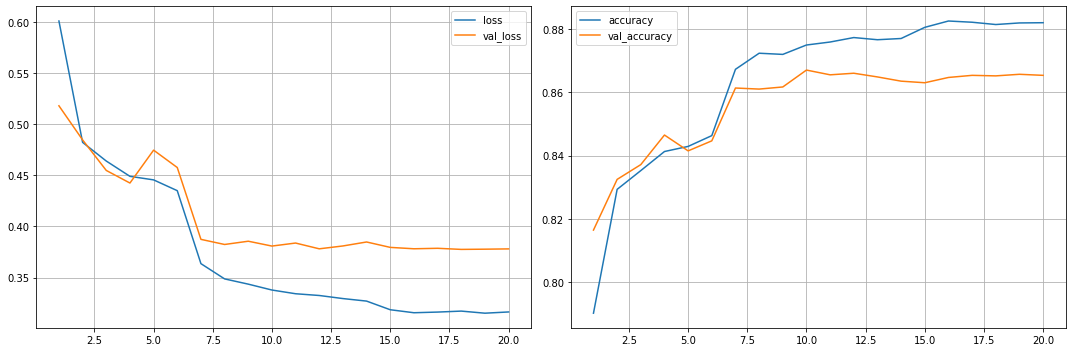

313/313 [==============================] - 5s 16ms/step - loss: 0.3582 - accuracy: 0.8705


[0.35818028450012207, 0.8705000281333923]

In [24]:
# Compile model
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              metrics=['accuracy'])
# Fit the model
early_stopping = EarlyStopping(monitor='val_loss', patience=6)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.00001)
model.fit(X_train_tl, y_train, epochs=20, batch_size=32, validation_split=.1, verbose=1,
          callbacks=[reduce_lr, early_stopping, PlotLearning()])

model.evaluate(X_test_tl, y_test)

In [25]:
len(model.layers)

432

In [5]:
model.layers[425].name

'conv5_block16_concat'

# Fine-Tuning the DenseNet121 model after Convergence

Once the model has converged on the new data, I try to unfreeze all of the base model and retrain the whole model end-to-end with a (very low) learning rate.

That can potentially give incremental improvements.

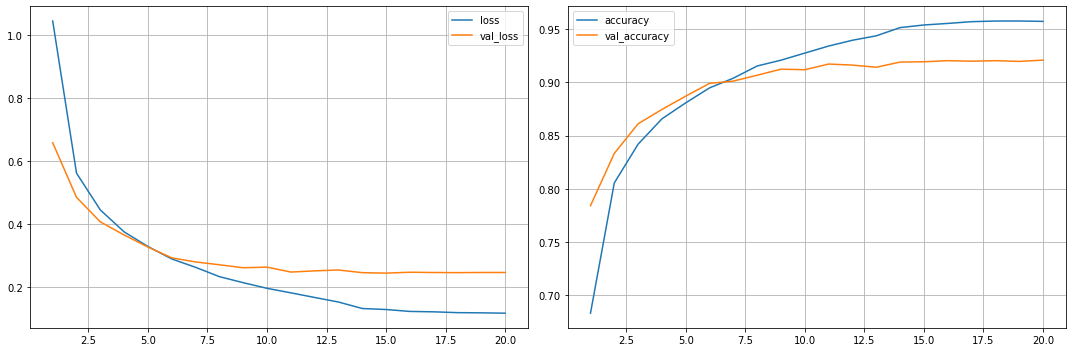

313/313 [==============================] - 5s 16ms/step - loss: 0.2349 - accuracy: 0.9215


[0.23489367961883545, 0.921500027179718]

In [27]:
model.trainable = True
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              metrics=['accuracy'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=1e-7)
model.fit(X_train_tl, y_train, epochs=20, batch_size=32, validation_split=.1, verbose=1,
          callbacks=[reduce_lr, early_stopping, PlotLearning()])

model.evaluate(X_test_tl, y_test)